# Inference Speedup

## Подготовка


In [4]:
import time
from typing import List
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn

import triton
import triton.language as tl


import math
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


print("torch version:", torch.__version__)
print("triton version:", triton.__version__)

from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer

torch version: 2.5.1+cu124
triton version: 3.1.0


### Catch activation ans weight

In [5]:
model_name = "Qwen/Qwen2.5-3B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=torch.float16,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
streamer = TextStreamer(tokenizer, skip_prompt=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [6]:
# challenging input
prompt = """
# SYSTEM PREAMBLE
1) You are an excellent Python software developer with over 10 years of experience. You have a strong understanding of Python related topics, data structures, libraries, frameworks, algorithms, best practices and optimization techniques.
2) You are here to help the user (the software developer) by breaking his request in ## TASK into logical steps and writing high-quality and efficient code to implement each step.
3) You have to return the entire code.
4) Follow "Answering rules" without exception.

## ANSWERING RULES
1) Repeat the question before answering it.
2) Always follow "CHAIN OF THOUGHTS" to execute the task.

## CHAIN OF THOUGHTS
1) **OBEY the EXECUTION MODE**
2) **TASK ANALYSIS:**
   - Understand the user's request thoroughly.
   - Identify the key components and requirements of the task.
3) **PLANNING: CODDING:**
   - Break down the task into logical, sequential steps.
   - Outline the strategy for implementing each step.
4) **CODING:**
   - Explain your thought process before writing any code.
   - Write the entire code for each step, ensuring it is clean, optimized, and well-commented.
   - Handle edge cases and errors appropriately.
5) **VERIFICATION:**
   - Review the complete code solution for accuracy and efficiency.
   - Ensure the code meets all requirements and is free of errors.

## TASK

Write a python function that receives the following JSON as input and enters data from it into the Google Sheet.

{
    'date': '31-05-2024',
    'revenue': 90000,
    'person' : 'User1',
    'expensesList': [30000, 14000, 10000, 2000, 15000],
    'expensesDescList': [ 'Ключи', 'Ключи2', 'Счет за такси', 'Клей, пластины', 'Провод 40м'],
    'expensesTypeList': ['Закупки', 'Закупки', 'Расходы', 'Ремонт', 'Ремонт']
}

There is a date in JSON, you can use it to determine the month.
The data is entered into a list with the name of the month. If such a list does not exist yet, then you need to create a list with a new month inside the sheet.

The list should have the following columns (the first rows are used as headings):
A1: Дата расхода,
B1: сумма расхода,
C1: описание расхода,
D1: тип расхода,
E1: кто внес данные

G1: Дата выручки
H1: Сумма выручки
I1: Кто внес данные

Please separate expenses and profits with a blank column.
Please sort expenses by date, including those already listed in Google sheet list.
Please sort earnings by date, including those already listed in Google sheet list.

It is prohibited to use oauth2client as it is deprecated.
"""

In [7]:
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
generation_output = model.generate(**model_inputs, streamer=streamer, max_new_tokens=1024)

To accomplish the task described, we will break it down into several steps:

1. Parse the input JSON and extract relevant information.
2. Prepare the data for insertion into the Google Sheet.
3. Create a Google Sheets API client using the `google-auth` library, which is recommended for handling authentication.
4. Insert the data into the specified columns in the Google Sheet.

Let's start by writing the Python function to handle these steps.

### Step 1: Parsing the JSON Input
First, let's define a function to parse the JSON input and prepare the data.

```python
import json

def parse_json(input_json):
    # Extract relevant fields from the JSON
    date = input_json['date']
    revenue = input_json['revenue']
    person = input_json['person']
    expenses_list = input_json['expensesList']
    expenses_desc_list = input_json['expensesDescList']
    expenses_type_list = input_json['expensesTypeList']

    # Create lists to store parsed data
    expenses_data = []
    profit_data = []



In [8]:
class Catcher(nn.Module):
    def __init__(self, inps: List, module: nn.Module):
        super().__init__()
        self.module = module
        self.inps = inps

    def forward(self, inp, **kwargs):
        self.inps.append(inp.to("cpu"))
        raise ValueError

In [9]:
layer = model.model.layers[0]
inps = []
layer.self_attn.q_proj = Catcher(inps, layer.self_attn.q_proj) # wrap

In [10]:
try:
    model(model_inputs.input_ids)
except ValueError as e:
    layer.self_attn.q_proj = layer.self_attn.q_proj.module

In [11]:
inps[0].shape

torch.Size([1, 700, 2048])

In [12]:
weight = layer.self_attn.q_proj.weight # unwrap

In [13]:
def is_cuda():
    return triton.runtime.driver.active.get_current_target().backend == "cuda"

assert is_cuda(), "CUDA only tutorial"
ref_lib = 'cuBLAS'

In [14]:
def get_cuda_autotune_config():
    return [
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32,  'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 256, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32,  'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
		    triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4),
		    triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
		    triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
		    triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
		    triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
		    triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
		    triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 256, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 256, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=8),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32,  'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32,  'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 256, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 8}, num_stages=3, num_warps=4),
    ]


def get_autotune_config():
    if is_cuda():
        return get_cuda_autotune_config()
    raise NotImplementedError("ooops")

## Задача

### Dynamic W8A8 GeMM

![](https://habrastorage.org/webt/xq/r5/8a/xqr58aw0gd6tdm-j45yqad67w1a.png)

In [15]:
@triton.autotune(
    configs=[
        triton.Config({}, num_stages=2, num_warps=8),
        triton.Config({}, num_stages=2, num_warps=4),
        triton.Config({}, num_stages=2, num_warps=2),
        triton.Config({}, num_stages=2, num_warps=1),
     ],
    key=['K'],
)
@triton.jit
def quantize_int8_perrow_kernel(
    fpa_ptr, a_ptr, as_ptr,
    M, K,
    stride_fpam, stride_fpak,
    stride_am, stride_ak,
    stride_asm,
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
):
    pid_m = tl.program_id(axis=0)
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M

    fpa_ptrs = fpa_ptr + offs_am[:, None] * stride_fpam + offs_k[None, :] * stride_fpak
    a_ptrs = a_ptr + offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak
    a_max = tl.zeros((BLOCK_SIZE_M,), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        fpa = tl.load(fpa_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        a_max = tl.maximum(a_max, tl.max(tl.abs(fpa), axis=1))
        fpa_ptrs += BLOCK_SIZE_K * stride_fpak

    a_scale =  tl.where(a_max == 0, 1.0, a_max / 127.0)
    scale_inv = 1 / a_scale

    fpa_ptrs = fpa_ptr + offs_am[:, None] * stride_fpam + offs_k[None, :] * stride_fpak
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        fpa = tl.load(fpa_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        scaled_fpa = fpa * scale_inv[:, None]
        rounded_fpa = tl.math.floor(scaled_fpa + 0.5)
        clamped_fpa = tl.maximum(rounded_fpa, -127.0)
        clamped_fpa = tl.minimum(clamped_fpa, 127.0)
        inta = clamped_fpa.to(tl.int8)
        tl.store(a_ptrs, inta, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K)
        fpa_ptrs += BLOCK_SIZE_K * stride_fpak
        a_ptrs += BLOCK_SIZE_K * stride_ak
    as_offs = pid_m * BLOCK_SIZE_M * stride_asm + tl.arange(0, BLOCK_SIZE_M)
    tl.store(as_ptr + as_offs, a_scale)


def quantize_int8_perrow(fpa):
    a = torch.empty(fpa.shape, device=fpa.device, dtype=torch.int8)
    a_scale = torch.empty(fpa.shape[0], device=fpa.device, dtype=fpa.dtype)
    M, K = fpa.shape
    BLOCK_SIZE_M = 1
    BLOCK_SIZE_K = triton.next_power_of_2(K)
    grid = (M // BLOCK_SIZE_M,)
    quantize_int8_perrow_kernel[grid](
        fpa, a, a_scale,
        M, K,
        fpa.stride(0), fpa.stride(1),
        a.stride(0), a.stride(1),
        a_scale.stride(0),
        BLOCK_SIZE_M, BLOCK_SIZE_K,
    )
    return a, a_scale


def quantize_int8(weight, axis=0, tp_rank=0):
    # Weight shape: [H1, H2]
    # Scale shape: [H2]

    scale = weight.abs().max(axis=axis, keepdim=True).values / 127.0

    weight = torch.clamp(torch.round(weight / scale), -127, 127).to(torch.int8)

    if axis == 0:
        weight = weight.t().contiguous().t()
    scale = scale.squeeze(axis)
    return weight.contiguous().cuda(tp_rank), scale.contiguous().cuda(tp_rank)


In [16]:
@triton.autotune(
    configs=get_autotune_config(),
    key=['M', 'N', 'K'],
    reset_to_zero=['c_ptr']
)
@triton.jit()
def perrow_w8a8_matmul_kernel(
    a_ptr, as_ptr, b_ptr, bs_ptr, c_ptr,
    M, N, K,
    stride_am, stride_ak,
    stride_asm,
    stride_bk, stride_bn,
    stride_bsn,
    stride_cm, stride_cn,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr, SPLIT_K: tl.constexpr,
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """

    pid = tl.program_id(axis=0)
    pid_sp_k = tl.program_id(axis=1)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = pid_sp_k * BLOCK_SIZE_K + tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)
    as_ptrs = as_ptr + offs_am * stride_asm
    bs_ptrs = bs_ptr + offs_bn * stride_bsn
    a_scale = tl.load(as_ptrs, mask=offs_am < M, other=0.0)
    b_scale = tl.load(bs_ptrs, mask=offs_bn < N, other=0.0)

    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.int32)

    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K * SPLIT_K)):
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K * SPLIT_K, other=0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K * SPLIT_K, other=0)

        accumulator += tl.dot(a,b, out_dtype=tl.int32)
        a_ptrs += BLOCK_SIZE_K * SPLIT_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * SPLIT_K * stride_bk

    c = accumulator.to(tl.float32) * a_scale.to(tl.float32)[:, None] * b_scale.to(tl.float32)[None, :]
    c = c.to(c_ptr.dtype.element_ty)

    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    if SPLIT_K == 1:
        tl.store(c_ptrs, c, mask=c_mask)
    else:
        tl.atomic_add(c_ptrs, c, mask=c_mask)


def matmul_int8(a, a_scale, b, b_scale, out=None):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    if out == None:
        c = torch.zeros((M, N), device=a.device, dtype=torch.float16)
    else:
        c = out.fill_(0.)


    grid = lambda META: (
        triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']),
        META['SPLIT_K'],
    )

    perrow_w8a8_matmul_kernel[grid](
        a, a_scale, b, b_scale, c,
        M, N, K,
        a.stride(0), a.stride(1),
        a_scale.stride(0),
        b.stride(0), b.stride(1),
        b_scale.stride(0),
        c.stride(0), c.stride(1),
    )

    return c


def matmul_quantize_int8(fpa, b, b_scale, out=None):
    a, a_scale = quantize_int8_perrow(fpa)
    return matmul_int8(a, a_scale, b, b_scale, out)


Sanity check (heavily relaxed for non-smoothed case):

In [17]:
torch.manual_seed(42)
cos = torch.nn.CosineSimilarity(0)

a = inps[0][0].to(torch.float16).cuda()
b = weight.to(torch.float16).cuda()

int_a, scale_a = quantize_int8_perrow(a)
int_b, scale_b = quantize_int8(b, axis=0)


triton_output = matmul_int8(int_a, scale_a, int_b, scale_b)
torch_output = torch.matmul(a, b)

if (torch_output.float() - triton_output.float()).abs().mean() < 0.03 and torch.quantile((torch_output.float() - triton_output.float()).abs(), 0.95) < 0.07:
    print("✅ Triton FP8 and Torch match")
else:
    print("❌ Triton FP8 and Torch differ")
    print("Quantization cos: ", cos((int_a * scale_a.unsqueeze(1)).flatten().to(torch.float32), a.flatten().to(torch.float32)).item())

    print('=' * 50)
    print(f"triton_output_with_fp8={triton_output}")
    print(f"torch_output={torch_output}")

    print('=' * 50)
    print("infs in triton:", (triton_output).isinf().sum())
    print("infs in torch:", (torch_output).isinf().sum())

    print('=' * 50)
    print("Output cos:", cos(triton_output.flatten().to(torch.float32), torch_output.flatten().to(torch.float32)).item())
    print(((triton_output - torch_output).abs() >= 0.5).sum())
    print(((triton_output - torch_output).abs() / (torch_output.abs() + 1e-5)))
    assert False, "Triton and Torch differ"

✅ Triton FP8 and Torch match


Sanity checks on perf:

In [18]:
def test_perf_quantize(M: int, K: int, iters: int = 256, thr: float = 1.3):
    torch.manual_seed(0)
    print(f"M: {M} K: {K}")

    a = torch.randn((M, K), device='cuda', dtype=torch.float16)
    # warmup
    for _ in range(10):
        int_a, a_scale = quantize_int8(a, 1)
        int_a, a_scale = quantize_int8_perrow(a)
    torch.cuda.synchronize()

    t1 = time.time()
    for _ in range(iters):
        int_a, a_scale = quantize_int8_perrow(a)
    torch.cuda.synchronize()
    t2 = time.time()
    for _ in range(iters):
        int_a, a_scale = quantize_int8(a, axis=1)
    torch.cuda.synchronize()
    t3 = time.time()

    torch_time = (t3 - t2) / iters
    triton_time = (t2 - t1) / iters

    print(f"Torch time cost: {torch_time}")
    print(f"Triton time cost: {triton_time}")
    assert torch_time / triton_time > thr, f"Must get at least {thr}x speedup"
    return triton_time, torch_time


def test_perf_matmul_int8(M, K, N, iters: int = 512, thr: float = 0.99):
    print("M: {} K: {} N: {}".format(M, K, N))
    torch.manual_seed(0)
    a = torch.randn((M, K), device='cuda', dtype=torch.float16)
    b = torch.randn((K, N), device='cuda', dtype=torch.float16).contiguous()
    int_b, scale_b = quantize_int8(b, axis=0)
    for _ in range(10):
        # int_a, a_scale = quantize_int8(a, 1)
        int_a, a_scale = quantize_int8_perrow(a)
        triton_output = matmul_int8(int_a, a_scale, int_b, scale_b)
    torch.cuda.synchronize()
    t1 = time.time()
    for _ in range(iters):
        #int_a, a_scale, _ = quantize_int8(a, 1)
        int_a, a_scale = quantize_int8_perrow(a)
    torch.cuda.synchronize()
    qt2 = time.time()
    for _ in range(iters):
        triton_output = matmul_int8(int_a, a_scale, int_b, scale_b)
    torch.cuda.synchronize()
    t2 = time.time()
    quant_time = qt2 - t1
    triton_time = t2 - qt2
    triton_tflops = 2 * M * N * K * 1e-12 / (triton_time / iters)
    quant_bandwith = 2 * M * K * 1e-9 / (quant_time / iters)
    print("Triton time cost: {} (tflops {}) + quant: {} (bandwidth {})".format(
        triton_time, triton_tflops, quant_time, quant_bandwith))
    for _ in range(10):
        torch_output = torch.matmul(a, b)
    torch.cuda.synchronize()
    iters = 512
    t1 = time.time()
    for _ in range(iters):
        torch_output = torch.matmul(a, b)
    torch.cuda.synchronize()
    t2 = time.time()
    torch_time = t2 - t1
    torch_tflops = 2 * M * N * K * 1e-12 / (torch_time / iters)
    print("Torch time cost: {} (tflops {})".format(t2 - t1, torch_tflops))

    assert torch_time / triton_time > thr, f"Must get at least {thr}x speedup"
    return triton_time, torch_time, quant_time


def test_perf_model_layer(bs, seq_len, hidden, inter, tp, thr: float = 0.99):
    st1 = 0
    st2 = 0
    st3 = 0
    t1, t2, t3 = test_perf_matmul_int8(bs * seq_len, hidden, hidden * 3 // tp, thr=thr)
    test_perf_quantize(bs * seq_len, hidden, thr=thr)
    st1 += t1
    st2 += t2
    st3 += t3
    t1, t2, t3 = test_perf_matmul_int8(bs * seq_len, hidden // tp, hidden, thr=thr)
    test_perf_quantize(bs * seq_len, hidden // tp, thr=thr)
    st1 += t1
    st2 += t2
    st3 += t3
    t1, t2, t3 = test_perf_matmul_int8(bs * seq_len, hidden, inter * 2 // tp, thr=thr)
    st1 += t1
    st2 += t2
    st3 += t3
    t1, t2, t3 = test_perf_matmul_int8(bs * seq_len, inter // tp, hidden, thr=thr)
    test_perf_quantize(bs * seq_len, inter // tp, thr=thr)
    st1 += t1
    st2 += t2
    st3 += t3
    print("Triton time {} Torch time {} Quant time {}".format(st1, st2, st3))
    assert st2 / st1 > thr, f"Must get at least {thr}x speedup"

In [19]:
bs = 32
hidden = model.config.hidden_size
inter  = model.config.intermediate_size
prefill_len = 512
decode_len = 1
tp = 1

In [21]:
test_perf_model_layer(bs, prefill_len, hidden, inter, tp, thr=0.1)

M: 16384 K: 2048 N: 6144
Triton time cost: 6.589658975601196 (tflops 32.03598749413768) + quant: 0.19909977912902832 (bandwidth 172.5754720487805)
Torch time cost: 9.745136260986328 (tflops 21.662727629385188)
M: 16384 K: 2048
Torch time cost: 0.0033701397478580475
Triton time cost: 0.00038675498217344284
M: 16384 K: 2048 N: 2048
Triton time cost: 2.310149908065796 (tflops 30.46068306302303) + quant: 0.22441768646240234 (bandwidth 153.10619635033282)
Torch time cost: 3.0129687786102295 (tflops 23.35528488619868)
M: 16384 K: 2048
Torch time cost: 0.003388570621609688
Triton time cost: 0.00038689374923706055
M: 16384 K: 2048 N: 22016
Triton time cost: 23.795056104660034 (tflops 31.79080547583755) + quant: 0.19931769371032715 (bandwidth 172.38679481178312)
Torch time cost: 38.99809169769287 (tflops 19.397461952084196)
M: 16384 K: 11008 N: 2048
Triton time cost: 11.51186728477478 (tflops 32.85583394930041) + quant: 1.4524989128112793 (bandwidth 127.14886882121586)
Torch time cost: 18.97908

In [24]:
test_perf_model_layer(bs, decode_len, hidden, inter, tp, thr=0.1)

M: 32 K: 2048 N: 6144
Triton time cost: 0.0757603645324707 (tflops 5.4423822134499105) + quant: 0.05654740333557129 (bandwidth 1.1867718063330595)
Torch time cost: 0.07208108901977539 (tflops 5.720180785599413)
M: 32 K: 2048
Torch time cost: 0.00015888456255197525
Triton time cost: 9.703915566205978e-05
M: 32 K: 2048 N: 2048
Triton time cost: 0.07096314430236816 (tflops 1.936765271933045) + quant: 0.050691843032836914 (bandwidth 1.3238592243830738)
Torch time cost: 0.027931690216064453 (tflops 4.920538370891506)
M: 32 K: 2048
Torch time cost: 0.00015168078243732452
Triton time cost: 9.517744183540344e-05
M: 32 K: 2048 N: 22016
Triton time cost: 0.11626315116882324 (tflops 12.707970969052775) + quant: 0.026458024978637695 (bandwidth 2.5364275698652468)
Torch time cost: 0.20558547973632812 (tflops 7.186639599834165)
M: 32 K: 11008 N: 2048
Triton time cost: 0.09786295890808105 (tflops 7.548661752664407) + quant: 0.025793790817260742 (bandwidth 13.984378897832235)
Torch time cost: 0.100939

Benchmarks:

In [25]:
@triton.autotune(
    configs=get_autotune_config(),
    key=['M', 'N', 'K'],
    reset_to_zero=['c_ptr']
)
@triton.jit
def matmul_kernel(
    # Pointers to matrices
    a_ptr, b_ptr, c_ptr,
    # Matrix dimensions
    M, N, K,
    # The stride variables represent how much to increase the ptr by when moving by 1
    # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
    # by to get the element one row down (A has M rows).
    stride_am, stride_ak,
    stride_bk, stride_bn,
    stride_cm, stride_cn,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr, SPLIT_K: tl.constexpr,
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    pid_sp_k = tl.program_id(axis=1)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetics` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = pid_sp_k * BLOCK_SIZE_K + tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)
    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K * SPLIT_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K * SPLIT_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K * SPLIT_K, other=0.0)
        # We accumulate along the K dimension.
        accumulator += tl.dot(a, b, allow_tf32=False)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * SPLIT_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * SPLIT_K * stride_bk
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    c = accumulator.to(c_ptr.dtype.element_ty)
    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    if SPLIT_K == 1:
        tl.store(c_ptrs, c, mask=c_mask)
    else:
        tl.atomic_add(c_ptrs, c, mask=c_mask)


seqlen = inps[0].shape[1]
hidden_size = inps[0].shape[2]
seqlen, hidden_size


def matmul(a, b):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    c = torch.zeros((M, N), device=a.device, dtype=torch.float16)
    grid = lambda META: (
        triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']),
        META['SPLIT_K'],
    )
    matmul_kernel[grid](
        a, b, c,
        M, N, K,
        a.stride(0), a.stride(1),
        b.stride(0), b.stride(1),
        c.stride(0), c.stride(1),
    )
    return c

def prepare_a(M: int):
    inp = inps[0][0]
    if M > seqlen:
        n_repeats = M // seqlen + 1
        return inp.repeat(n_repeats, 1)[:M]
    else:
        return inp[:M]

def benchmark(M, provider, provider_funcs):
    N = weight.shape[0]
    K = weight.shape[1]

    a = prepare_a(M).to(torch.float16).cuda()
    b = weight.T.to(torch.float16)
    assert a.shape == (M, K), f"{a.shape} != {(M, K)}"
    assert b.shape == (K, N), b.shape

    quantiles = [0.5, 0.2, 0.8]
    ms, min_ms, max_ms = triton.testing.do_bench(lambda: provider_funcs[provider](a, b), quantiles=quantiles)
    perf = lambda ms: ms # TFlops = 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

@torch.no_grad()
def benchmark_quant_gemm(M, provider, provider_funcs):
    N = weight.shape[0]
    K = weight.shape[1]

    fpa = prepare_a(M).to(torch.float16).cuda().contiguous()
    fpb = weight.data.T.to(torch.float16).contiguous()
    b, b_scale = quantize_int8(fpb, axis=0)

    assert fpa.shape == (M, K), f"{fpa.shape} != {(M, K)}"
    assert b.shape == (K, N), b.shape

    quantiles = [0.5, 0.2, 0.8]
    ms, min_ms, max_ms = triton.testing.do_bench(lambda: provider_funcs[provider](fpa, fpb, b, b_scale), quantiles=quantiles)
    perf = lambda ms: ms # TFlops = 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

In [26]:
provider_funcs = {
    "triton int8": lambda fpa, fpb, b, b_scale: matmul_quantize_int8(fpa, b, b_scale),
    "triton fp16": lambda fpa, fpb, b, b_scale: matmul(fpa, fpb),
    "cublas fp16": lambda fpa, fpb, b, b_scale: torch.matmul(fpa, fpb)
}

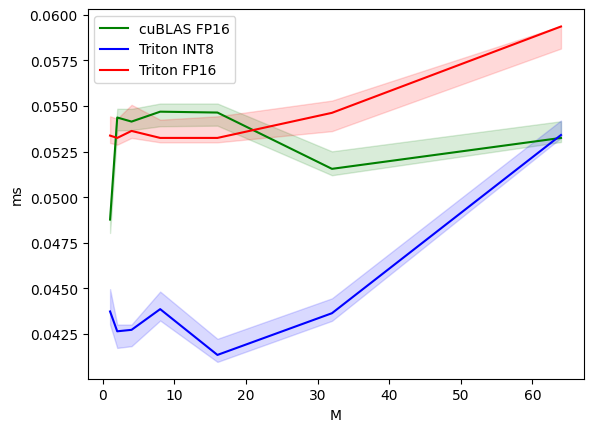

GeMV-performance-FP16 vs INT8:
      M  cuBLAS FP16  Triton INT8  Triton FP16
0   1.0     0.048768     0.043728     0.053376
1   2.0     0.054368     0.042640     0.053248
2   4.0     0.054144     0.042720     0.053632
3   8.0     0.054688     0.043856     0.053248
4  16.0     0.054640     0.041344     0.053248
5  32.0     0.051552     0.043632     0.054624
6  64.0     0.053248     0.053408     0.059360


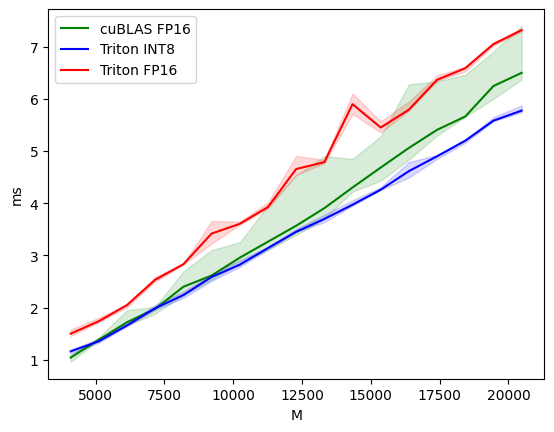

GeMM-performance-FP16 vs INT8:
          M  cuBLAS FP16  Triton INT8  Triton FP16
0    4096.0     1.044240     1.163088     1.502224
1    5120.0     1.386208     1.356576     1.741056
2    6144.0     1.721088     1.660704     2.050512
3    7168.0     1.977888     1.990304     2.535488
4    8192.0     2.400288     2.241184     2.832640
5    9216.0     2.615328     2.588480     3.418672
6   10240.0     2.957120     2.822480     3.605504
7   11264.0     3.263280     3.142496     3.927888
8   12288.0     3.568672     3.452832     4.655104
9   13312.0     3.905856     3.698720     4.787008
10  14336.0     4.300800     3.971488     5.897040
11  15360.0     4.683712     4.259184     5.450048
12  16384.0     5.058768     4.614592     5.791264
13  17408.0     5.405536     4.898880     6.364048
14  18432.0     5.661152     5.197504     6.585776
15  19456.0     6.244416     5.581184     7.046592
16  20480.0     6.497216     5.774240     7.315648


In [27]:
configs = [
    triton.testing.Benchmark(
        x_names=["M"],
        x_vals=[2 ** i for i in range(7)],
        line_arg="provider",
        line_vals=["cublas fp16", "triton int8", "triton fp16"],
        line_names=["cuBLAS FP16", "Triton INT8", "Triton FP16"],
        styles=[("green", "-"), ("blue", "-"), ("red", "-")],
        ylabel="ms",
        plot_name="GeMV-performance-" + ("FP16 vs INT8"),
        args={"provider_funcs": provider_funcs},
    ),
    triton.testing.Benchmark(
        x_names=["M"],
        x_vals=[1024 * i for i in range(4, 21)],
        line_arg="provider",
        line_vals=["cublas fp16", "triton int8", "triton fp16"],
        line_names=["cuBLAS FP16", "Triton INT8", "Triton FP16"],
        styles=[("green", "-"), ("blue", "-"), ("red", "-")],
        ylabel="ms",
        plot_name="GeMM-performance-" + ("FP16 vs INT8"),
        args={"provider_funcs": provider_funcs},
    ),
]


triton.testing.perf_report(configs)(benchmark_quant_gemm).run(show_plots=True, print_data=True)

In [28]:
provider_funcs = {
    "torch": lambda a, b: quantize_int8(a),
    "triton": lambda a, b: quantize_int8_perrow(a)
}

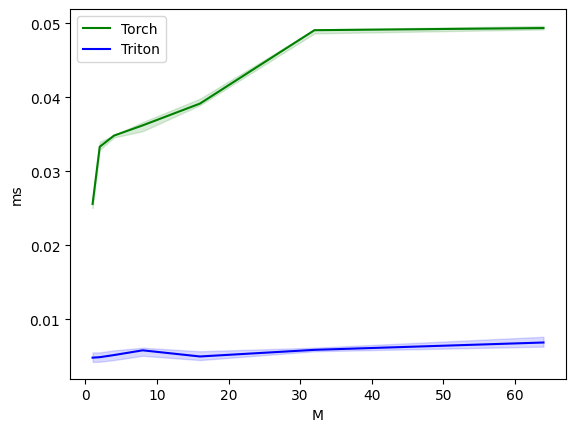

Quantize-performance-decoding:
      M     Torch    Triton
0   1.0  0.025568  0.004800
1   2.0  0.033296  0.004864
2   4.0  0.034816  0.005152
3   8.0  0.036192  0.005792
4  16.0  0.039136  0.004960
5  32.0  0.049056  0.005856
6  64.0  0.049344  0.006848


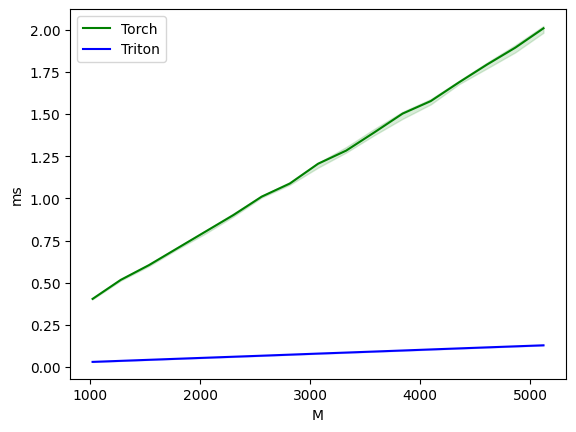

Quantize-performance-prefill:
         M     Torch    Triton
0   1024.0  0.403968  0.030720
1   1280.0  0.516736  0.036864
2   1536.0  0.604160  0.043008
3   1792.0  0.703232  0.049152
4   2048.0  0.802272  0.055184
5   2304.0  0.901120  0.061248
6   2560.0  1.009984  0.067328
7   2816.0  1.087616  0.073568
8   3072.0  1.204768  0.079872
9   3328.0  1.282848  0.085904
10  3584.0  1.390928  0.092032
11  3840.0  1.501936  0.098176
12  4096.0  1.576224  0.104448
13  4352.0  1.686976  0.110592
14  4608.0  1.793024  0.116736
15  4864.0  1.892832  0.122848
16  5120.0  2.007584  0.128992


In [29]:
configs = [
    triton.testing.Benchmark(
        x_names=["M"],
        x_vals=[2 ** i for i in range(7)],
        line_arg="provider",
        line_vals=["torch", "triton"],
        line_names=["Torch", "Triton"],
        styles=[("green", "-"), ("blue", "-")],
        ylabel="ms",
        plot_name="Quantize-performance-" + ("decoding"),
        args={"provider_funcs": provider_funcs},
    ),
    triton.testing.Benchmark(
        x_names=["M"],
        x_vals=[256 * i for i in range(4, 21)],
        line_arg="provider",
        line_vals=["torch", "triton"],
        line_names=["Torch", "Triton"],
        styles=[("green", "-"), ("blue", "-")],
        ylabel="ms",
        plot_name="Quantize-performance-" + ("prefill"),
        args={"provider_funcs": provider_funcs},
    ),
]


triton.testing.perf_report(configs)(benchmark).run(show_plots=True, print_data=True)


--- Running: M=16384 K=2048 N=6144 ---
M: 16384 K: 2048 N: 6144
Triton time cost: 6.7147228717803955 (tflops 31.43930681341993) + quant: 0.19782161712646484 (bandwidth 173.69051404546076)
Torch time cost: 9.85541820526123 (tflops 21.420322114823577)
M: 16384 K: 2048
Torch time cost: 0.0033578258007764816
Triton time cost: 0.0003871927037835121
 Triton mat: 6.714723s | quant: 0.197822s | total: 6.912544s | TFLOPS: 0.06
 Torch  mat: 9.855418s | quant: 0.003358s | total: 9.858776s | TFLOPS: 0.04
 Speedup (Torch / Triton total): 1.426x

--- Running: M=16384 K=2048 N=2048 ---
M: 16384 K: 2048 N: 2048
Triton time cost: 2.289278984069824 (tflops 30.738387355727244) + quant: 0.2219984531402588 (bandwidth 154.77467469690654)
Torch time cost: 2.965735673904419 (tflops 23.7272474404379)
M: 16384 K: 2048
Torch time cost: 0.003362836316227913
Triton time cost: 0.0003872038796544075
 Triton mat: 2.289279s | quant: 0.221998s | total: 2.511277s | TFLOPS: 0.06
 Torch  mat: 2.965736s | quant: 0.003363s

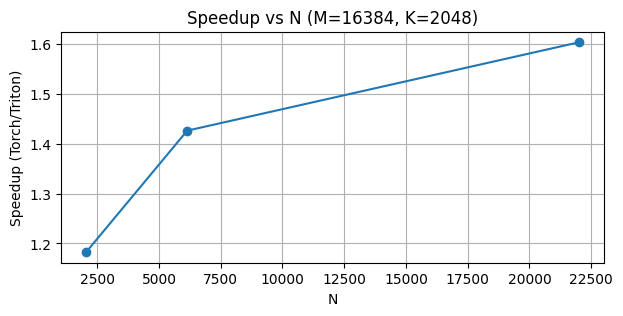

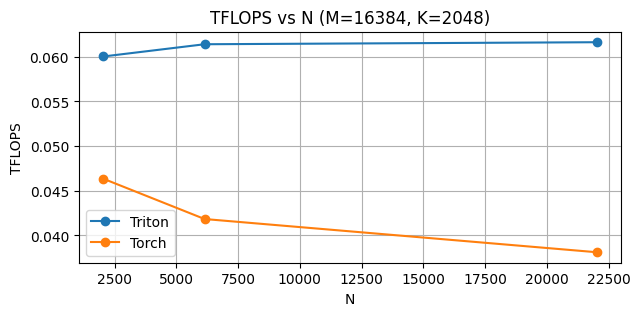

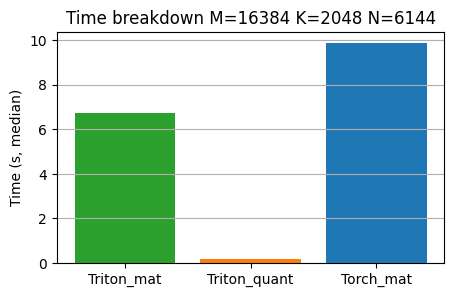

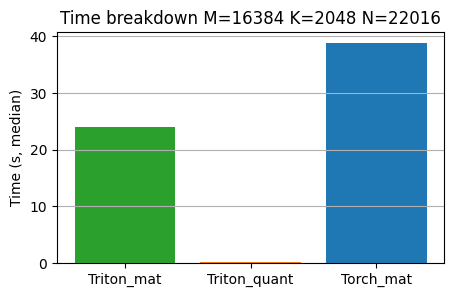

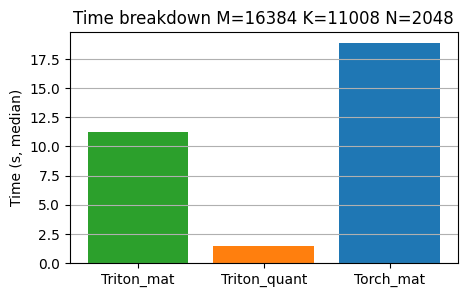

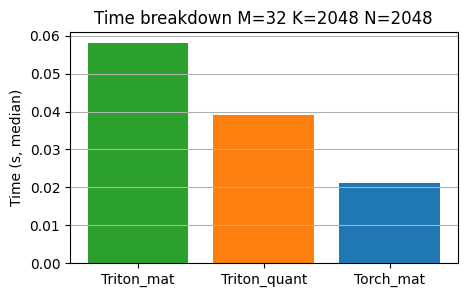

In [30]:
plt.rcParams.update({'figure.max_open_warning': 0})

def run_checks_and_report(shapes, iters_mat=512, iters_q=256, thr=0.99):
    rows = []
    for M, K, N in shapes:
        print(f"\n--- Running: M={M} K={K} N={N} ---")
        try:
            t_triton, t_torch, t_quant = test_perf_matmul_int8(M, K, N, iters=iters_mat, thr=thr)
        except AssertionError as e:
            print(f"[WARN] matmul assert: {e} — retrying without assert to get timings")
            try:
                t_triton, t_torch, t_quant = test_perf_matmul_int8(M, K, N, iters=iters_mat, thr=0.0)
            except Exception as e2:
                print(f"[ERROR] matmul failed: {e2}")
                t_triton, t_torch, t_quant = (np.nan, np.nan, np.nan)
        except Exception as e:
            print(f"[ERROR] matmul exception: {e}")
            t_triton, t_torch, t_quant = (np.nan, np.nan, np.nan)

        # try separate quant measure (best-effort)
        tq_triton, tq_torch = (np.nan, np.nan)
        try:
            tq_triton, tq_torch = test_perf_quantize(M, K, iters=iters_q, thr=thr)
        except AssertionError as e:
            # keep best-effort values
            try:
                tq_triton, tq_torch = test_perf_quantize(M, K, iters=iters_q, thr=0.0)
            except Exception:
                tq_triton, tq_torch = (np.nan, np.nan)
        except Exception:
            tq_triton, tq_torch = (np.nan, np.nan)

        # choose best quant time available (from matmul-run or separate)
        quant_triton = t_quant if not math.isnan(t_quant) else tq_triton
        quant_torch  = tq_torch

        ops = 2.0 * M * N * K
        triton_tflops = ops * 1e-12 / t_triton if not math.isnan(t_triton) and t_triton>0 else np.nan
        torch_tflops  = ops * 1e-12 / t_torch  if not math.isnan(t_torch)  and t_torch>0  else np.nan

        triton_total = (t_triton if not math.isnan(t_triton) else 0.0) + (quant_triton if not math.isnan(quant_triton) else 0.0)
        torch_total  = (t_torch if not math.isnan(t_torch) else 0.0) + (quant_torch if not math.isnan(quant_torch) else 0.0)

        speedup = (torch_total / triton_total) if (triton_total>0 and not math.isnan(torch_total) and not math.isnan(triton_total)) else np.nan

        row = {
            "M": M, "K": K, "N": N,
            "triton_mat_s": float(t_triton) if not math.isnan(t_triton) else np.nan,
            "triton_quant_s": float(quant_triton) if not math.isnan(quant_triton) else np.nan,
            "triton_total_s": float(triton_total) if not math.isnan(triton_total) else np.nan,
            "triton_tflops": float(triton_tflops) if not math.isnan(triton_tflops) else np.nan,
            "torch_mat_s": float(t_torch) if not math.isnan(t_torch) else np.nan,
            "torch_quant_s": float(quant_torch) if not math.isnan(quant_torch) else np.nan,
            "torch_total_s": float(torch_total) if not math.isnan(torch_total) else np.nan,
            "torch_tflops": float(torch_tflops) if not math.isnan(torch_tflops) else np.nan,
            "speedup_total": float(speedup) if not math.isnan(speedup) else np.nan
        }
        rows.append(row)

        # quick one-line summary for this triple
        print(f" Triton mat: {row['triton_mat_s']:.6f}s | quant: {row['triton_quant_s']:.6f}s | total: {row['triton_total_s']:.6f}s | TFLOPS: {row['triton_tflops']:.2f}")
        print(f" Torch  mat: {row['torch_mat_s']:.6f}s | quant: {row['torch_quant_s']:.6f}s | total: {row['torch_total_s']:.6f}s | TFLOPS: {row['torch_tflops']:.2f}")
        print(f" Speedup (Torch / Triton total): {row['speedup_total']:.3f}x")

    df = pd.DataFrame(rows)
    # Print compact overall stats
    print("\n=== Aggregate stats ===")
    measured = df.dropna(subset=["speedup_total"])
    if len(measured)==0:
        print("No valid measurements collected.")
        return df

    mean_speedup = measured["speedup_total"].mean()
    median_speedup = measured["speedup_total"].median()
    print(f"Measured combos: {len(measured)}")
    print(f"Mean speedup (torch/triton total): {mean_speedup:.3f}x")
    print(f"Median speedup: {median_speedup:.3f}x")
    print("\nPer-(M,K) summary:")
    for (M,K), g in measured.groupby(["M","K"]):
        print(f" M={M}, K={K}  points={len(g)}  mean_speed={g['speedup_total'].mean():.3f}  median_speed={g['speedup_total'].median():.3f}")

    # 1) speedup vs N for M=16384 per K
    for (M,K), g in df.groupby(["M","K"]):
        if M==16384 and g["N"].nunique()>=3:
            g_sorted = g.sort_values("N")
            plt.figure(figsize=(7,3))
            plt.plot(g_sorted["N"], g_sorted["speedup_total"], marker='o')
            plt.title(f"Speedup vs N (M={M}, K={K})")
            plt.xlabel("N"); plt.ylabel("Speedup (Torch/Triton)")
            plt.grid(True)
            plt.show()
    # 2) TFLOPS vs N for M=16384 per K (if >=3 points)
    for (M,K), g in df.groupby(["M","K"]):
        if M==16384 and g["N"].nunique()>=3:
            g_sorted = g.sort_values("N")
            plt.figure(figsize=(7,3))
            plt.plot(g_sorted["N"], g_sorted["triton_tflops"], marker='o', label='Triton')
            plt.plot(g_sorted["N"], g_sorted["torch_tflops"], marker='o', label='Torch')
            plt.title(f"TFLOPS vs N (M={M}, K={K})")
            plt.xlabel("N"); plt.ylabel("TFLOPS"); plt.legend(); plt.grid(True)
            plt.show()

    # 3) Breakdown bar for a few notable triples
    notable = [(16384,2048,6144),(16384,2048,22016),(16384,11008,2048),(32,2048,2048)]
    for (M,K,N) in notable:
        subset = df[(df["M"]==M)&(df["K"]==K)&(df["N"]==N)]
        if not subset.empty:
            r = subset.iloc[0]
            labels = ["Triton_mat","Triton_quant","Torch_mat"]
            values = [r["triton_mat_s"], r["triton_quant_s"], r["torch_mat_s"]]
            plt.figure(figsize=(5,3))
            plt.bar(labels, values, color=["#2ca02c","#ff7f0e","#1f77b4"])
            plt.title(f"Time breakdown M={M} K={K} N={N}")
            plt.ylabel("Time (s, median)")
            plt.grid(axis='y')
            plt.show()

    return df

shapes = [
    (16384, 2048, 6144),
    (16384, 2048, 2048),
    (16384, 2048, 22016),
    (16384, 11008, 2048),
    (32, 2048, 6144),
    (32, 2048, 2048),
    (32, 2048, 22016),
    (32, 11008, 2048),
]

df_results = run_checks_and_report(shapes, iters_mat=512, iters_q=256, thr=0.99)